In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom.load(f'{parent}/assets/hand_phantom')

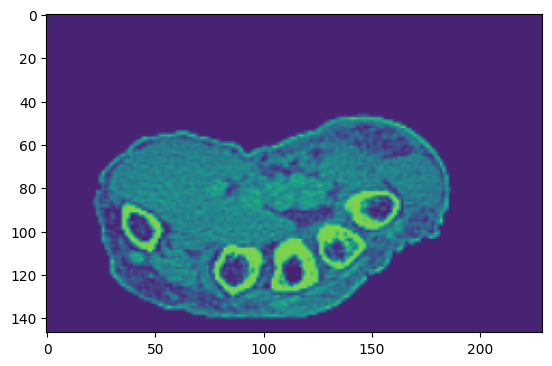

In [3]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)

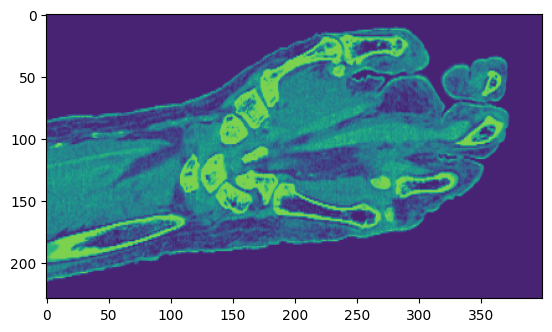

In [4]:
plt.imshow(test_phantom.get_complete()[0, 90, :, :], vmin=1500, vmax=2000)

In [5]:
z_heights = np.arange(-0.09, 0.09, 0.002)

num_transducers = 6
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 64, 
#                                     width = 60e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/4,
#                                     ray_num = 5, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 60e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 256,
                                    width = 80e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5, 
                                    imaging_ndims = 2,
                                    focus_elevation = 60e-3,
                                    ) for i in range(num_transducers * len(z_heights))]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [6]:
z_heights = np.arange(-0.09, 0.09, 0.002)

for i in range(len(z_heights)):
    rotations = [geometry.Transform((r,0,0),(0,0,0)) for r in np.linspace(0, 2 * np.pi, num_transducers, endpoint=False)]
    positions = [rot.apply_to_point((-0.07,0,z_heights[i])) for rot in rotations]
    for j in range(num_transducers):
        rotations[j].translation = positions[j]
        test_transducer_set.assign_pose(i * num_transducers + j, rotations[j])

In [7]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

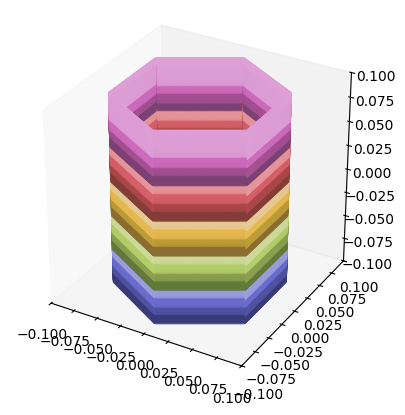

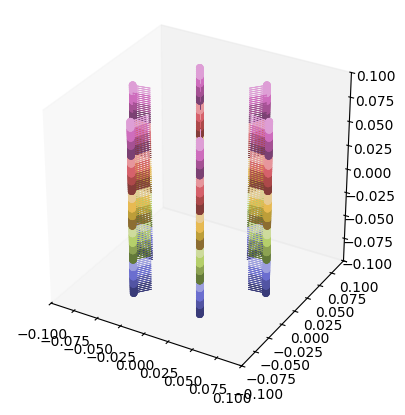

In [8]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [9]:
# simprops = simulation.SimProperties(
#                 grid_size   = (90e-3,20e-3,20e-3),
#                 voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
#                 PML_size    = (32,8,8),
#                 PML_alpha   = 2,
#                 t_end       = 12e-5,           # [s]
#                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
#                 alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
#                 alpha_power = 1.5,
#                 grid_lambda = 2,               # 
#                 )

simprops = simulation.SimProperties(
                grid_size   = (100e-3,100e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [10]:
test_experiment = experiment.Experiment(
                 simulation_path = f'invitro_arm_experiment_1mhz_3D',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


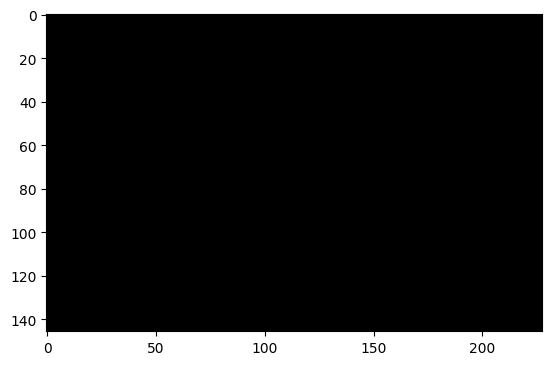

In [38]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_experiment.phantom.mask.shape[2]//2])

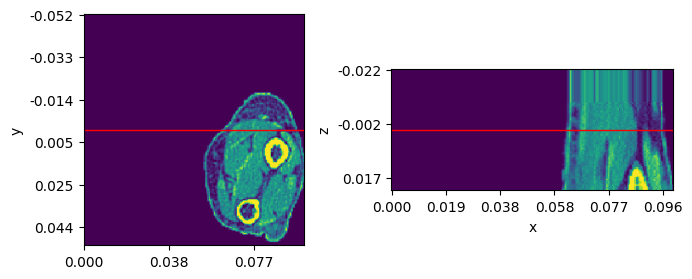

In [39]:
test_experiment.plot_ray_path(2)

In [2]:
test_experiment = experiment.Experiment.load('invitro_arm_experiment_1mhz_exa')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


In [61]:
test_experiment.run(repeat=True)

running with 5 workers

preparation for sim    0 completed in 27.86 seconds
preparation for sim    8 completed in 29.43 seconds
preparation for sim   16 completed in 29.81 seconds
preparation for sim    1 completed in 25.79 seconds
preparation for sim   23 completed in 28.69 seconds
preparation for sim    9 completed in 26.43 seconds
preparation for sim   17 completed in 24.68 seconds
simulation             0 completed in 34.20 seconds
preparation for sim    2 completed in 27.54 seconds
simulation             8 completed in 27.82 seconds
simulation            16 completed in 31.83 seconds
simulation             1 completed in 34.41 seconds
preparation for sim   18 completed in 29.60 seconds
preparation for sim   10 completed in 29.64 seconds
preparation for sim    3 completed in 29.79 seconds
preparation for sim   24 completed in 28.43 seconds
simulation            23 completed in 39.77 seconds
simulation             9 completed in 33.22 seconds
simulation            17 completed in 33

In [3]:
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(test_experiment)

In [4]:
images = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 30/30 [00:00<00:00, 699050.67it/s]


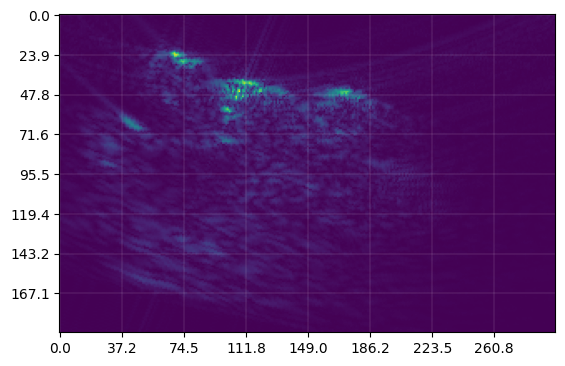

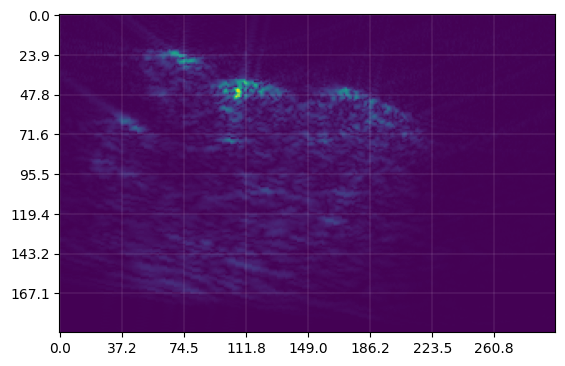

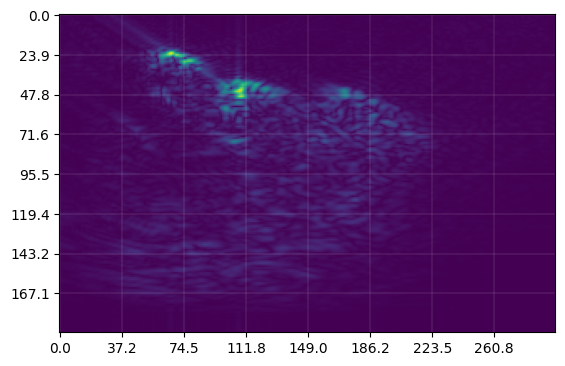

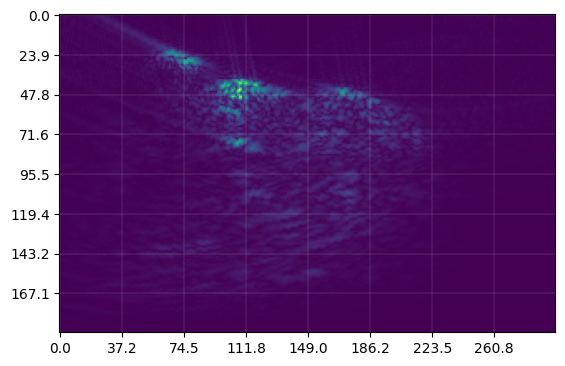

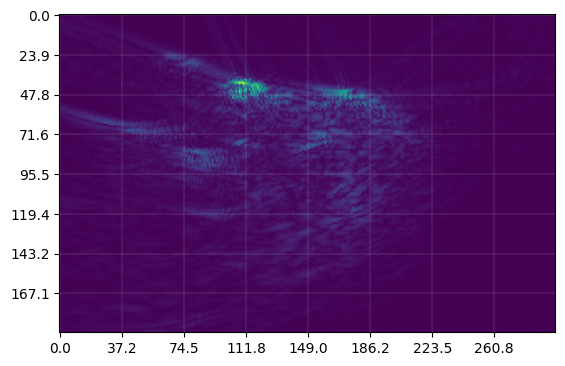

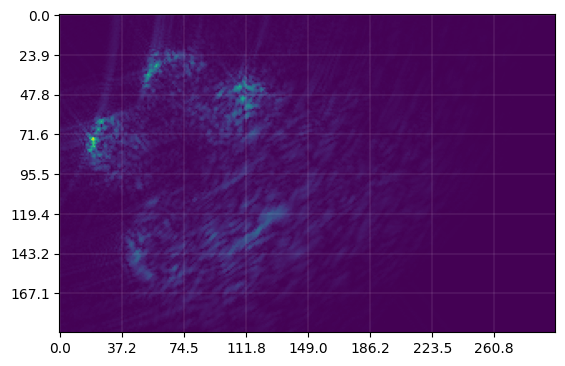

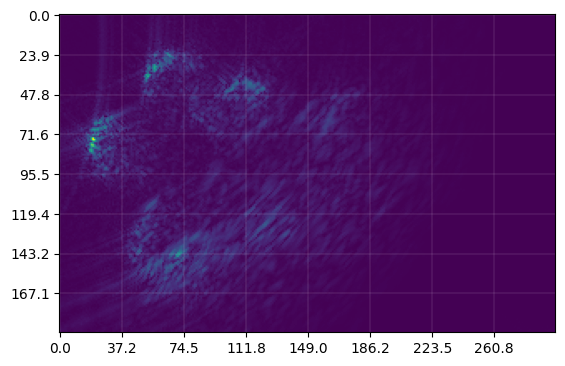

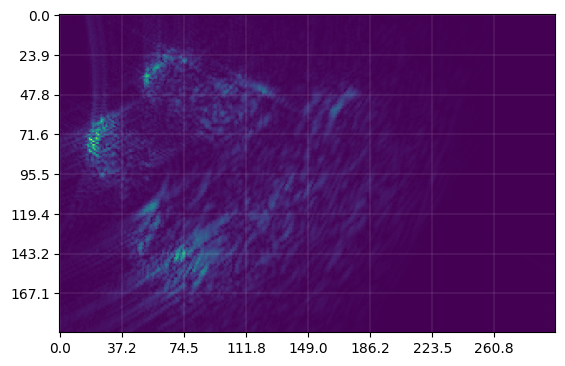

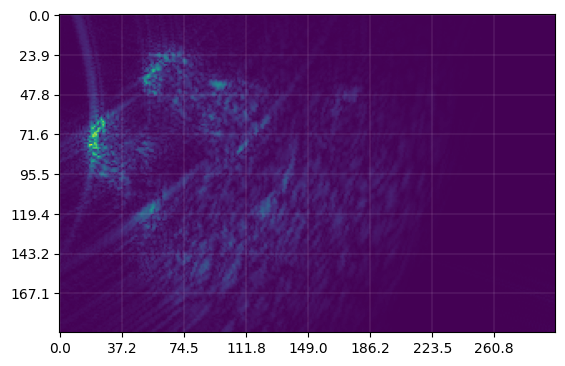

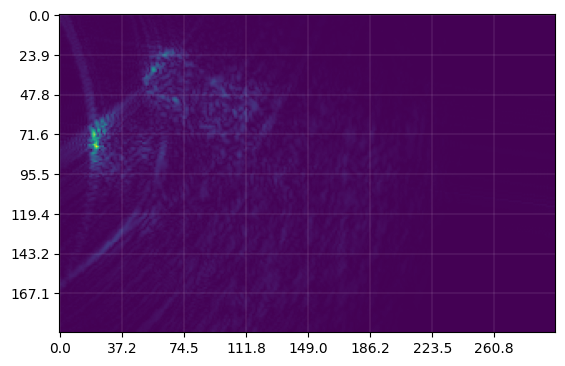

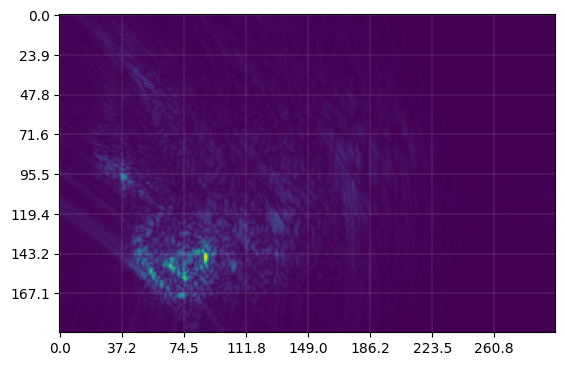

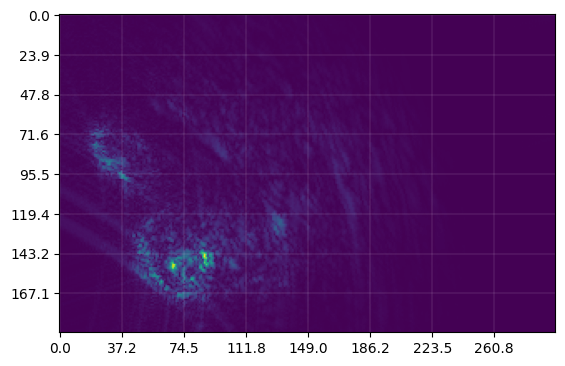

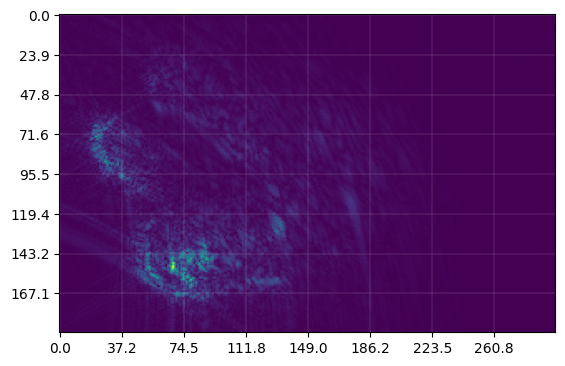

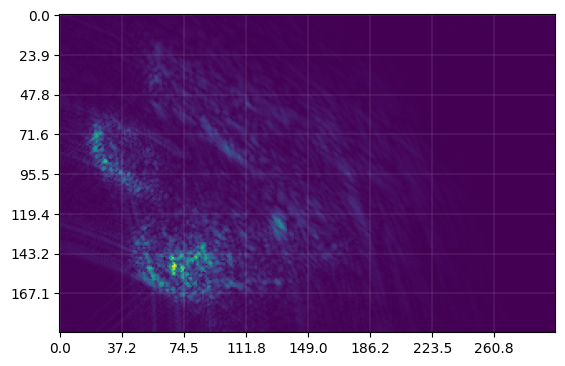

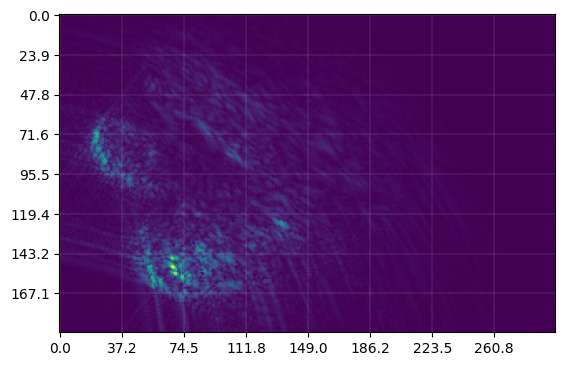

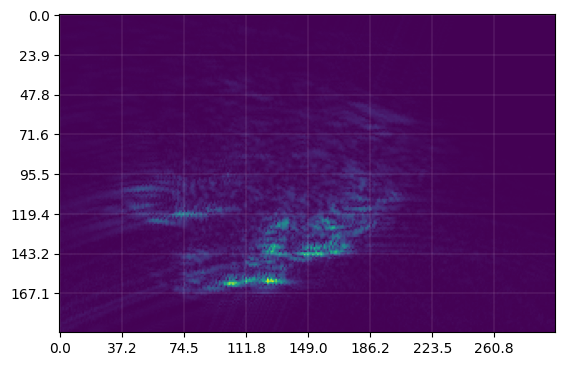

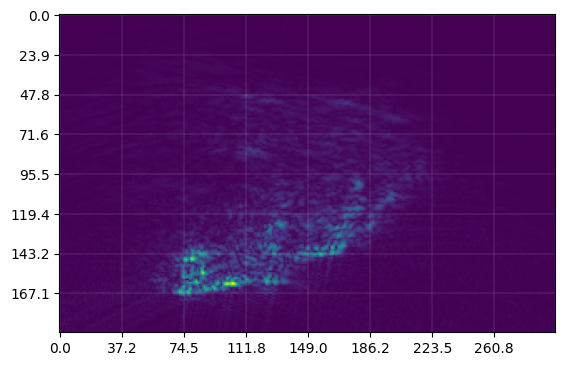

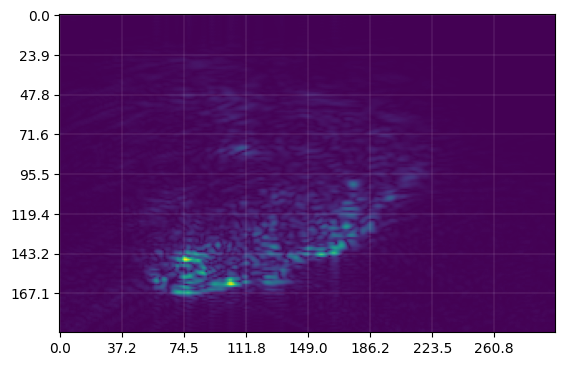

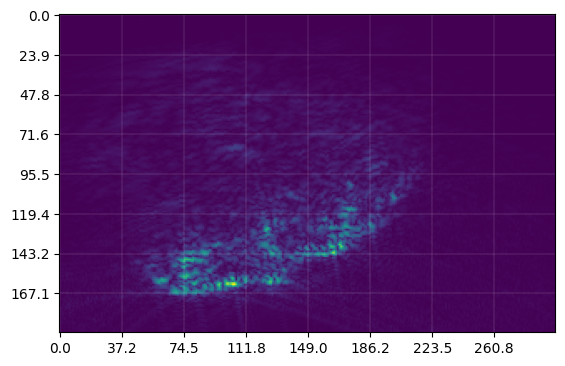

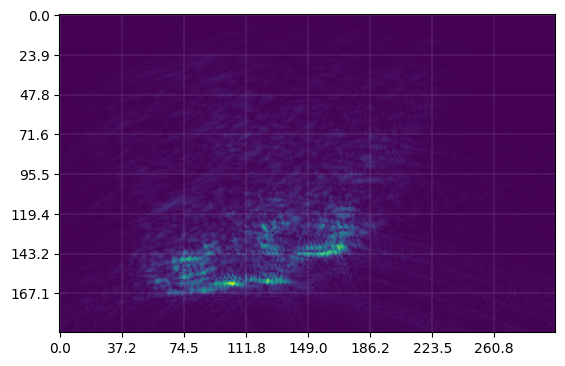

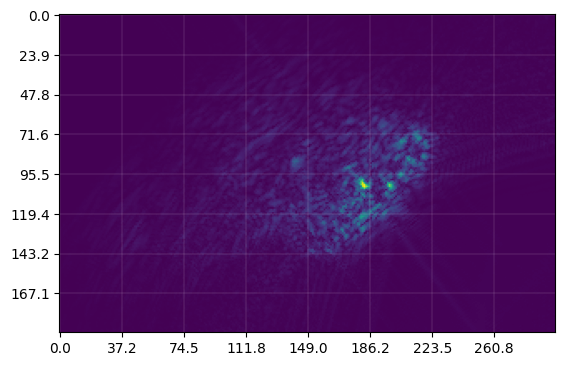

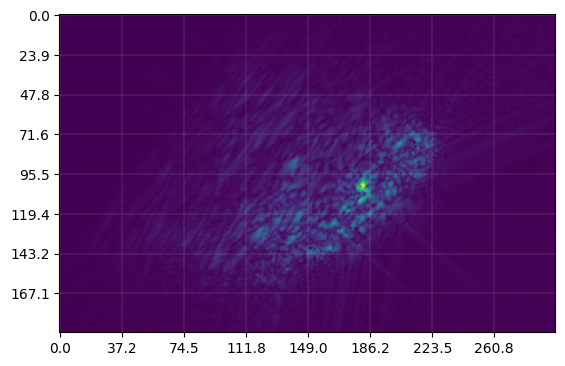

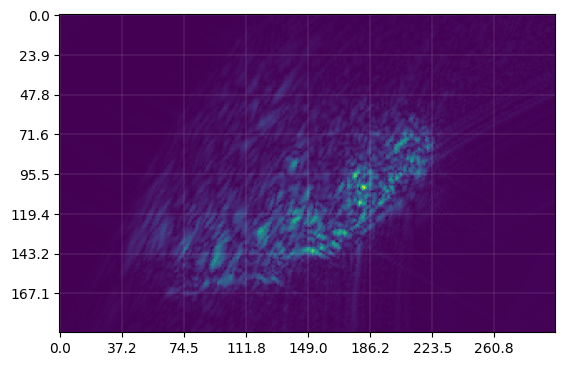

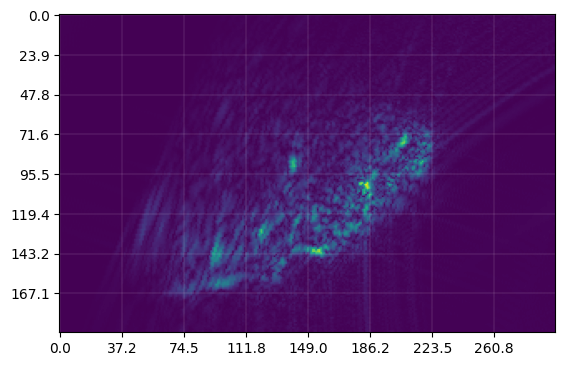

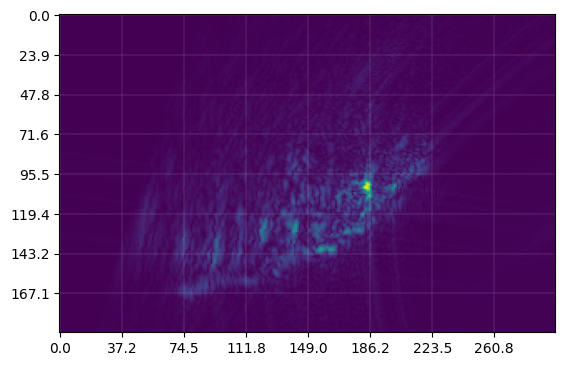

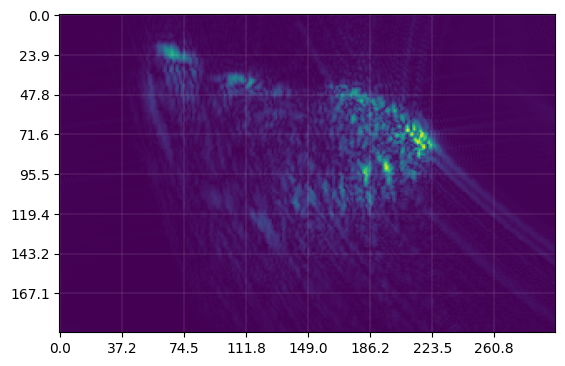

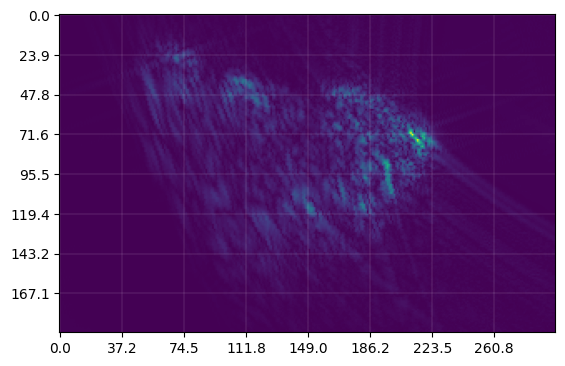

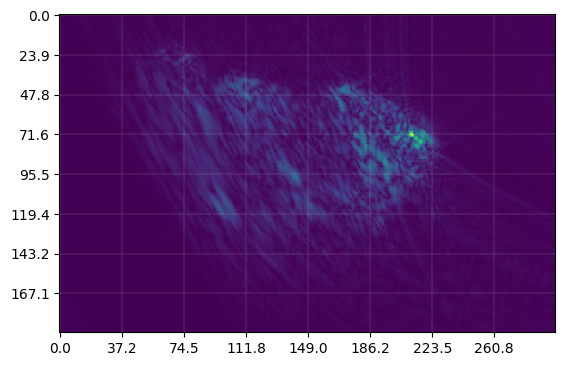

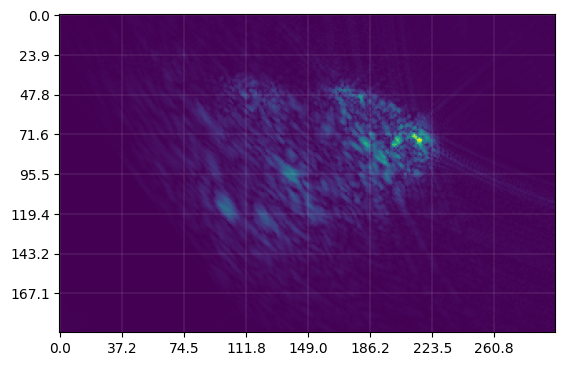

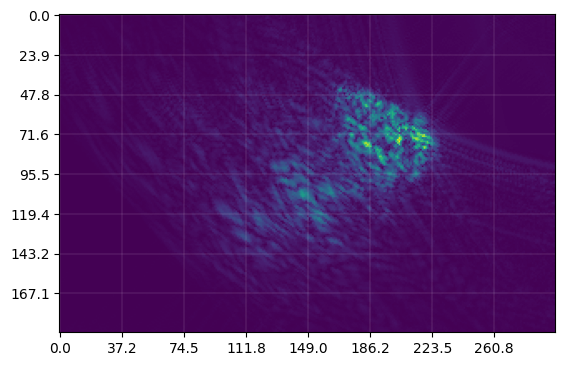

In [5]:
for image in images:
    plt.xticks(np.linspace(0, image.shape[1],9))
    plt.yticks(np.linspace(0, image.shape[0],9))
    plt.imshow(image[:,:,image.shape[2]//2])
    plt.grid(color='w', linestyle='-', linewidth=0.1)
    plt.show()

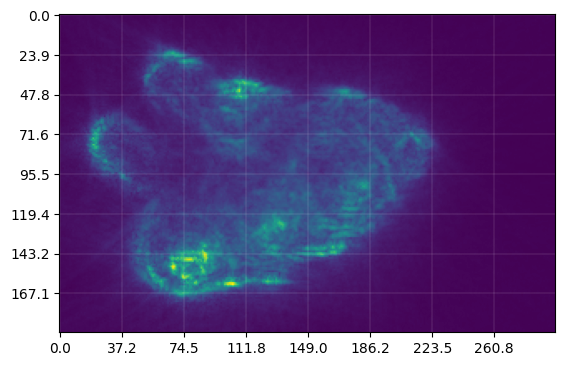

In [6]:
plt.xticks(np.linspace(0, image.shape[1],9))
plt.yticks(np.linspace(0, image.shape[0],9))
plt.imshow(np.sum(images, axis=0)[:,:,image.shape[2]//2])
plt.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()